In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [3]:
df = pd.read_csv('master_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df

,status_update,Openness,Consciousness,Extraversion,Agreeablenes,Neuroticism
0,likes the sound of thunder.,4.4,3.25,2.65,3.15,3.00
1,is so sleepy it's not even funny that's she ca...,4.4,3.25,2.65,3.15,3.00
2,is sore and wants the knot of muscles at the b...,4.4,3.25,2.65,3.15,3.00
3,likes how the day sounds in this new song.,4.4,3.25,2.65,3.15,3.00
4,is home. <3,4.4,3.25,2.65,3.15,3.00
...,...,...,...,...,...,...
570149,can't wait until next sunday! <3,3.0,4.00,4.00,4.50,1.25
570150,babysitting :),3.0,4.00,4.00,4.50,1.25
570151,"Dear COD,\r\ni hate you. You consistantly stea...",3.0,4.00,4.00,4.50,1.25
570152,is in an amazing mood for some unknown reason XD,3.0,4.00,4.00,4.50,1.25


In [5]:
df_1 = df.drop(['Openness','Consciousness','Extraversion','Agreeablenes'], axis=1)

In [6]:
df_1['Neuroticism'].value_counts()

2.75    49841
3.00    46210
3.25    39221
2.25    38850
2.50    38214
        ...  
2.58       19
2.18       16
2.81       10
3.74        2
1.56        1
Name: Neuroticism, Length: 176, dtype: int64

In [7]:
df_1 = df_1[df_1['status_update'].str.len() >= 50].reset_index(drop=True)
#50 characters is the amount of characters for a average sentence

In [8]:
def number_map(x):
    if x > 3.50:
        return 1
    else:
        return 0

In [9]:
df_1['Neuroticism'] = df_1['Neuroticism'].apply(number_map)
# A Neuroticism score higher than median means being of risk to depression *0-5

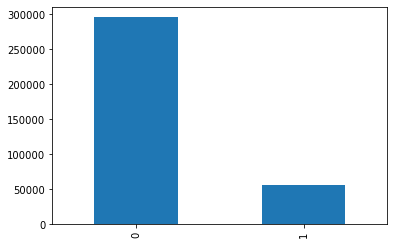

In [10]:
df_1['Neuroticism'].value_counts().plot(kind='bar');
# will need to over sample

# Text Preprocessing

In [11]:
import re

df_1['status_update'] = df_1['status_update'].apply(lambda x:re.sub(r'[^\w\s]', '', x)) 
#lambda function removes punctuations

In [12]:
import nltk
#from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True) 

tokenizer = RegexpTokenizer(r"(?u)\w{3,}[a-zA-Z]")

lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokens]

# Modeling Preparation

### Train, Validation, and Test split

In [13]:
X = df_1['status_update']
y = df_1['Neuroticism']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.25, random_state=42)
## TRAIN TEST SPLIT

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.25, random_state=42)
## TRAIN Validation SPLIT

### TFIDF  Vectorization

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# my token pattern has been applied inside of "lemmatize_and_tokenize" function
tfidf = TfidfVectorizer(max_features = 500, stop_words='english', tokenizer=lemmatize_and_tokenize)

In [17]:
X_train_vectorized = tfidf.fit_transform(X_train)

# My "X_train_vectorized" will be resampled

In [18]:
X_val_vectorized = tfidf.transform(X_val)
X_val_df = pd.DataFrame.sparse.from_spmatrix(X_val_vectorized, columns=tfidf.get_feature_names())

### Count Vectorizer

In [111]:
# from sklearn.feature_extraction.text import CountVectorizer

# CV = CountVectorizer(max_features=500, stop_words='english', tokenizer=lemmatize_and_tokenize)

In [112]:
# X_train_Cvectorized = CV.fit_transform(X_train["status_update"])

# # My "X_train_vectorized" will be resampled

In [113]:
# X_val_Cvectorized = CV.transform(X_val['status_update'])
# X_val_df_C = pd.DataFrame.sparse.from_spmatrix(X_val_Cvectorized, columns=CV.get_feature_names())

In [114]:
# X_test_Cvectorized = CV.transform(X_test['status_update'])
# X_test_df_C = pd.DataFrame.sparse.from_spmatrix(X_test_Cvectorized, columns=CV.get_feature_names())

### Fixing Imbalance

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(sampling_strategy='minority',random_state=42)

X_train_ros, y_train_ros = smote.fit_resample(X_train_vectorized, y_train)

print('Old shape of y:' + str(Counter(y_train)))
print('New shape of y:' + str(Counter(y_train_ros)))

Old shape of y:Counter({0: 166402, 1: 31759})
New shape of y:Counter({0: 166402, 1: 166402})


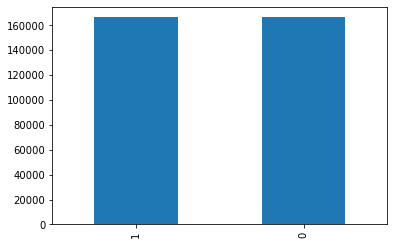

In [20]:
y_train_ros.value_counts().plot(kind='bar');

In [23]:
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_ros, columns=tfidf.get_feature_names())
print(X_train_df.columns.tolist())

['able', 'actually', 'aint', 'alot', 'amazing', 'answer', 'anymore', 'apparently', 'asked', 'away', 'awesome', 'baby', 'ball', 'band', 'bday', 'beach', 'beat', 'beautiful', 'believe', 'best', 'better', 'birthday', 'bitch', 'black', 'blessed', 'blood', 'blue', 'body', 'book', 'bored', 'bought', 'bout', 'boy', 'brain', 'break', 'bring', 'broke', 'broken', 'brother', 'busy', 'called', 'came', 'cancer', 'card', 'care', 'catch', 'cause', 'cell', 'chance', 'change', 'check', 'chicken', 'child', 'chocolate', 'christmas', 'church', 'city', 'class', 'clean', 'close', 'coffee', 'cold', 'college', 'color', 'come', 'coming', 'comment', 'computer', 'cool', 'copy', 'country', 'couple', 'course', 'crap', 'crazy', 'cute', 'damn', 'dance', 'date', 'daughter', 'day', 'dead', 'dear', 'death', 'decided', 'didnt', 'died', 'different', 'dinner', 'doctor', 'doe', 'doesnt', 'doing', 'dont', 'door', 'dream', 'drink', 'drive', 'driving', 'early', 'earth', 'easy', 'eating', 'english', 'enjoy', 'everybody', 'exam

# First Simple Model

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report

In [24]:
logreg = LogisticRegression()

logreg.fit(X_train_df, y_train_ros)

y_train_preds = logreg.predict(X_train_df)
y_val_pred = logreg.predict(X_val_df)

In [25]:
training_accuracy = accuracy_score(y_train_ros, y_train_preds)
validation_accuracy = accuracy_score(y_val,y_val_pred)

print(f'Training accuracy:{training_accuracy}')
print(f'validation accuracy:{validation_accuracy}')

Training accuracy:0.5848397254840687
validation accuracy:0.5664153571320435


              precision    recall  f1-score   support

           0       0.85      0.59      0.70     55537
           1       0.17      0.44      0.25     10517

    accuracy                           0.57     66054
   macro avg       0.51      0.52      0.47     66054
weighted avg       0.74      0.57      0.62     66054



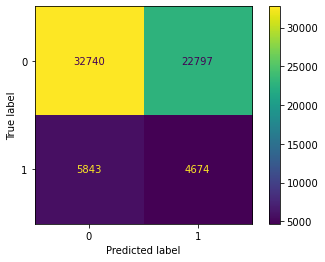

In [29]:
print(classification_report(y_val, y_val_pred))
plot_confusion_matrix(logreg,X_val_df,y_val);